In [200]:
import pandas as pd
import statsmodels.api as sm

In [201]:
df = pd.read_excel("stadat_nepmozgalom.xls", header=[1,2])

In [202]:
df["Élveszületés "]

,összesen,ezer lakosra
0,268019,39.7
1,265457,35.1
2,249458,31.4
3,219784,25.4
4,177047,18.9
...,...,...
72,93063,9.482656
73,91577,9.356081
74,89807,9.186887
75,89193,9.128207


In [203]:
birth = df["Élveszületés "]["ezer  lakosra"]
birth

0         39.7
1         35.1
2         31.4
3         25.4
4         18.9
        ...   
72    9.482656
73    9.356081
74    9.186887
75    9.128207
76          ..
Name: ezer  lakosra, Length: 77, dtype: object

In [204]:
year = df["Év"]["Unnamed: 0_level_1"]
year

0     1900
1     1910
2     1920
3     1930
4     1941
      ... 
72    2016
73    2017
74    2018
75    2019
76    2020
Name: Unnamed: 0_level_1, Length: 77, dtype: int64

In [205]:
ts = birth.set_axis(year, axis="index")
ts.index.name = "year"
ts.name = "birth rate"
ts

year
1900        39.7
1910        35.1
1920        31.4
1930        25.4
1941        18.9
          ...   
2016    9.482656
2017    9.356081
2018    9.186887
2019    9.128207
2020          ..
Name: birth rate, Length: 77, dtype: object

In [206]:
mask = ts.apply(lambda x: type(x) in (int, float) or x.isnumeric())
ts = ts[mask].astype(float)
ts

year
1900    39.700000
1910    35.100000
1920    31.400000
1930    25.400000
1941    18.900000
          ...    
2015     9.315223
2016     9.482656
2017     9.356081
2018     9.186887
2019     9.128207
Name: birth rate, Length: 76, dtype: float64

In [207]:
ts = ts.reindex(range(ts.index.min(), ts.index.max()))

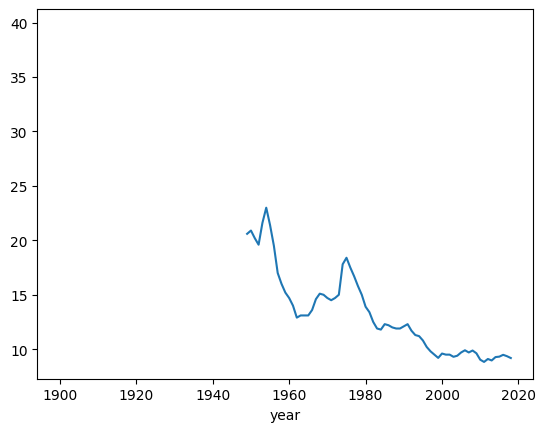

In [208]:
ts.plot();

In [209]:
ts.dropna().index

Index([1900, 1910, 1920, 1930, 1941, 1949, 1950, 1951, 1952, 1953, 1954, 1955,
       1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018],
      dtype='int64', name='year')

In [210]:
ts = ts.loc[1949:]

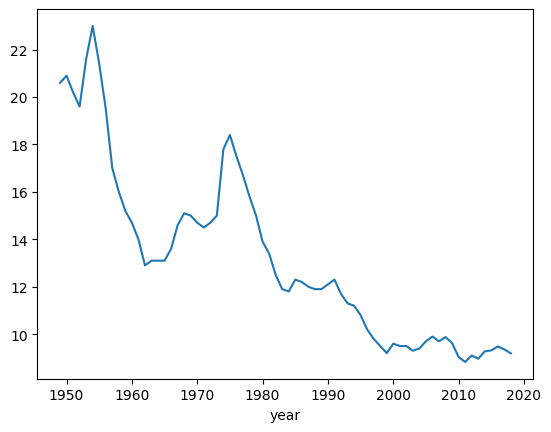

In [211]:
ts.plot();

In [212]:
model = sm.OLS(ts.to_numpy(), sm.add_constant(ts.index.to_numpy()))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     241.8
Date:                Tue, 26 Nov 2024   Prob (F-statistic):           4.39e-24
Time:                        15:17:38   Log-Likelihood:                -138.22
No. Observations:                  70   AIC:                             280.4
Df Residuals:                      68   BIC:                             284.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        335.8930     20.750     16.187      0.000     294.486     377.300
x1            -0.1627      0.010    -15.551      0.000      -0.184      -0.142
==============================================================================
Omnibus:                        2.830   Durbin-Watson:                   0.186
Prob(Omnibus):                  0.243   Jarque-Bera (JB):                2.064
Skew:                           0.382   Prob(JB):                        0.356
Kurtosis:                       3.353   Cond. No.                     1.95e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.95e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

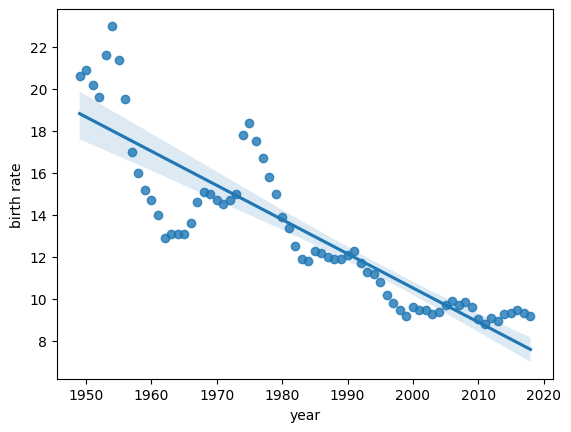

In [213]:
import seaborn as sns

ts_df = pd.DataFrame(ts).reset_index()
sns.regplot(ts_df, x="year", y="birth rate");

# Autokorreláció
## A korábbi értékek befolyásolják-e a későbbieket

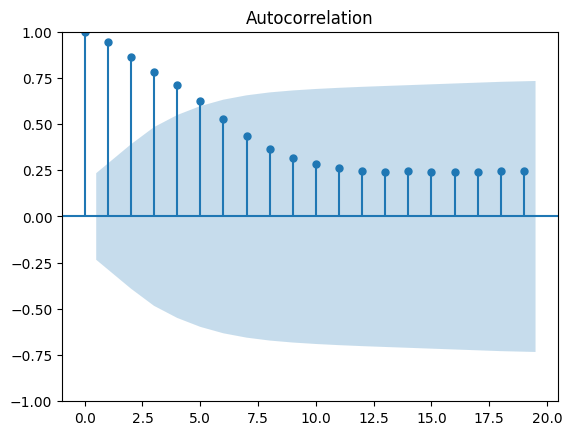

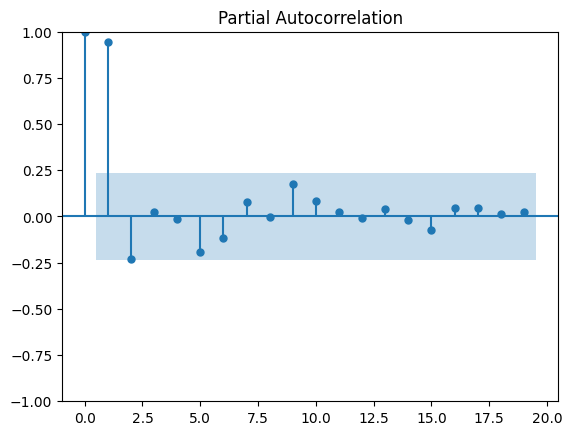

In [214]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts);  # információ átcsordulással (spillover effect)
plot_pacf(ts);  # kontrollált eset (nincs spillover)

# Mozgóátlag (Moving Average, q) 
### Mekkora az ablak mérete? 
- amekkora lag mellett az autokorreláció szignifikáns

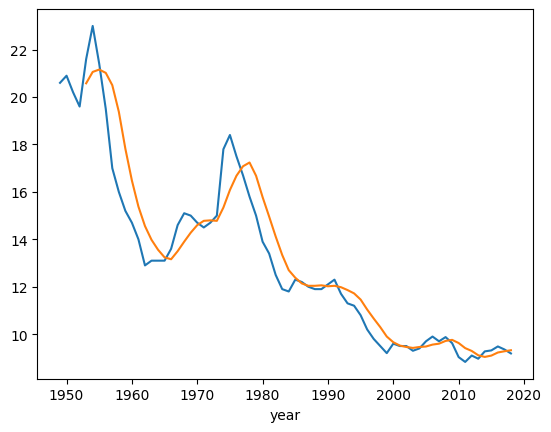

In [215]:
ts_rolling = ts.rolling(5).mean()
ts.plot()
ts_rolling.plot();

# Autoregresszív modell (AR, p)
- az adatot önmagval regresszáljuk
- predikció korábbi megfigyelések alapján (időben)
- feltétel: (gyenge) stacionaritás (konstans szórás és átlag - nincs trend és szezonalitás)
- p tag: PACF-ből jön

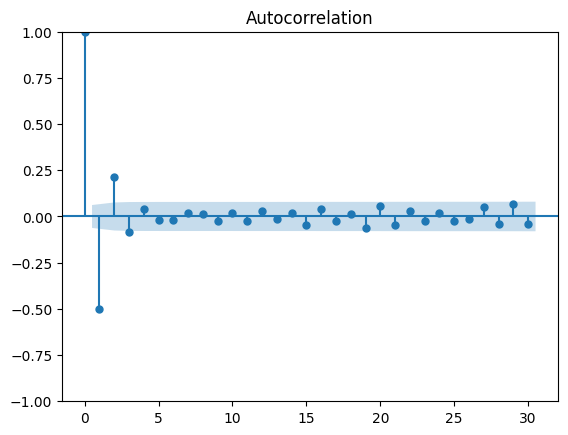

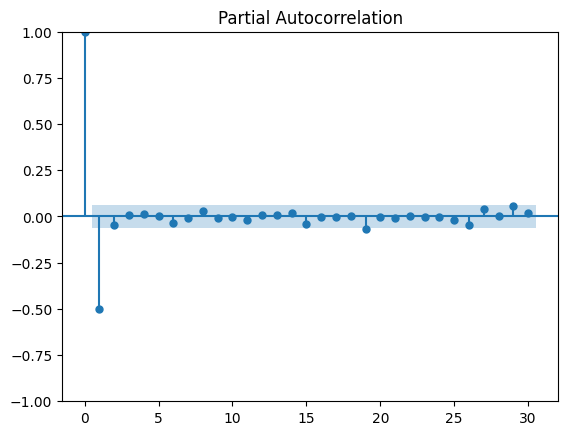

In [216]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np


def ar_ma_process(theta=0, phi=0):
    """
    Parameters
    ----------
    theta: float
        MA parameter
    phi: float
        AR parameter
    """
    steps = 1000
    if not isinstance(theta, list):
        theta = [theta]
    if not isinstance(phi, list):
        phi = [phi]
        
    ma_coeff = np.array([1] + theta) 
    ar_coeff = np.array([1] + phi)
    process = ArmaProcess(ar_coeff, ma_coeff).generate_sample(nsample=steps)
    plot_acf(process)
    plot_pacf(process)
    return process
    

x = ar_ma_process(phi=0.5)

# Stacionaritás

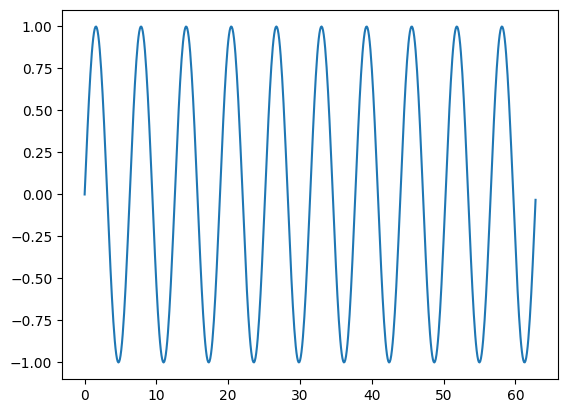

In [217]:
import numpy as np
import matplotlib.pyplot as plt

# valami ilyesmit szeretnénk látni egy stacionárius idősorban (enyhe eltérések lehetnek, de viszonylag állandó paramétereket kellenek)
x = np.arange(0, 20*np.pi, 0.1) 
y = np.sin(x)
plt.plot(x, y);

## Legegyszerűbb megoldás: vegyük a k-adik lag mellett differenciált idősort és teszteljük, stac.-e
- tesztelés: vizuálisan vagy statisztikai teszttel (pl Augmented Dickey-Fuller teszt)



0
ADF teszt p-érték: 0.223
1
ADF teszt p-érték: 0.0
2
ADF teszt p-érték: 0.0
3
ADF teszt p-érték: 0.002
4
ADF teszt p-érték: 0.001


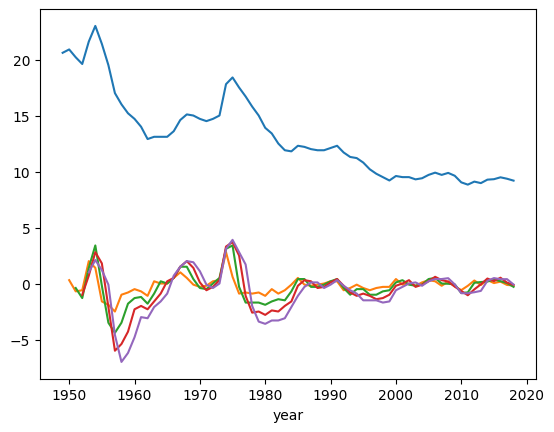

In [218]:

from statsmodels.tsa.stattools import adfuller

for k in range(0, 5):
    temp = ts.diff(k) if k > 0 else ts
    temp.plot()
    print(k)
    p_value = round(adfuller(temp.dropna())[1], 3)
    print(f"ADF teszt p-érték: {p_value}")

## Szezonális dekompozíció
- elemire szedjük az idősort
-   trend, szezodnlitás, reziduálisok
- additív vagy multiplicatív az idősor?

### Additív idősor
- állandó szezonalitás és konstans variancia
- lineáris trend
- domainspecifikus feltételezés

### Multiplikatív 
- ~ additív ellentetje (kivéve az uccsó pontot :)

In [219]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts.index = dt_index = pd.to_datetime(ts.index.tolist(), format="%Y")
ts

1949-01-01    20.600000
1950-01-01    20.900000
1951-01-01    20.200000
1952-01-01    19.600000
1953-01-01    21.600000
                ...    
2014-01-01     9.274849
2015-01-01     9.315223
2016-01-01     9.482656
2017-01-01     9.356081
2018-01-01     9.186887
Name: birth rate, Length: 70, dtype: float64

In [220]:
pd.date_range("1949", "2018", freq="y")

C:\Users\witen\AppData\Local\Temp\ipykernel_13664\491732524.py:1: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pd.date_range("1949", "2018", freq="y")


DatetimeIndex(['1949-12-31', '1950-12-31', '1951-12-31', '1952-12-31',
               '1953-12-31', '1954-12-31', '1955-12-31', '1956-12-31',
               '1957-12-31', '1958-12-31', '1959-12-31', '1960-12-31',
               '1961-12-31', '1962-12-31', '1963-12-31', '1964-12-31',
               '1965-12-31', '1966-12-31', '1967-12-31', '1968-12-31',
               '1969-12-31', '1970-12-31', '1971-12-31', '1972-12-31',
               '1973-12-31', '1974-12-31', '1975-12-31', '1976-12-31',
               '1977-12-31', '1978-12-31', '1979-12-31', '1980-12-31',
               '1981-12-31', '1982-12-31', '1983-12-31', '1984-12-31',
               '1985-12-31', '1986-12-31', '1987-12-31', '1988-12-31',
               '1989-12-31', '1990-12-31', '1991-12-31', '1992-12-31',
               '1993-12-31', '1994-12-31', '1995-12-31', '1996-12-31',
               '1997-12-31', '1998-12-31', '1999-12-31', '2000-12-31',
               '2001-12-31', '2002-12-31', '2003-12-31', '2004-12-31',
      

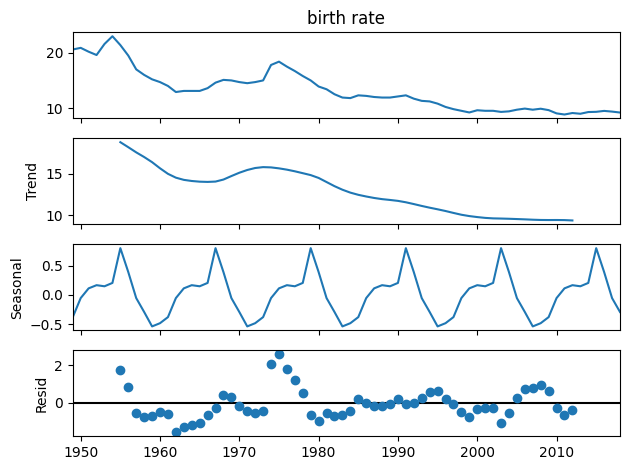

In [221]:
decomp = seasonal_decompose(ts, model="additive", period=12)
decomp.plot();

# ARIMA modell

- AR és MA modell kombinálva + az idősor integrálása
- Tényleges megfigyelések hatása (AR modell) és a véletlen sokkok (hibatagok hatása, MA modell) együttesen írják le a folyamatot
- ACF és PACF is sziniszfüggvényre emlékeztető, lecsengő jelleget vesz fel
- q és p paraméterek nem azonosíthatók egyértelműen
- **Megoldás**: iteratív modellépítés

In [232]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

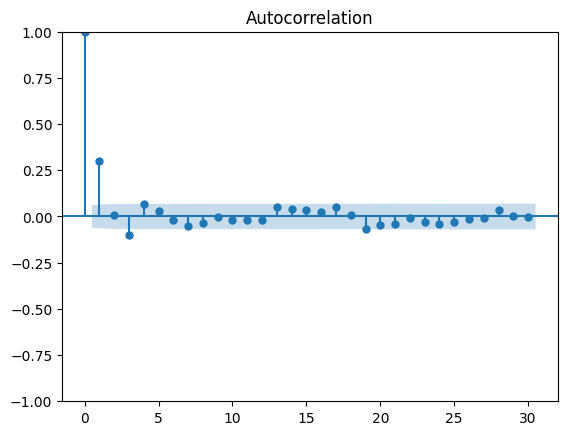

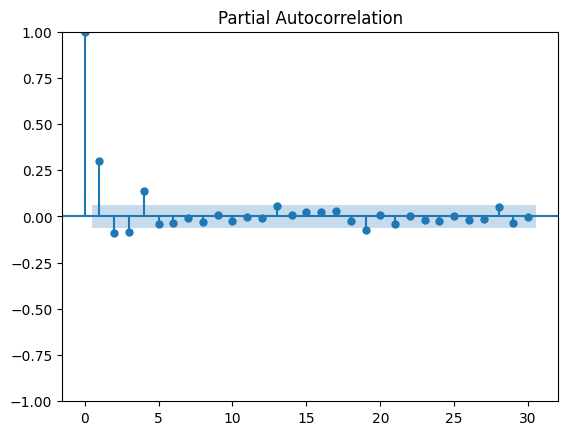

In [223]:
x = ar_ma_process([0.8, 0.5], [0.5, 0.3])

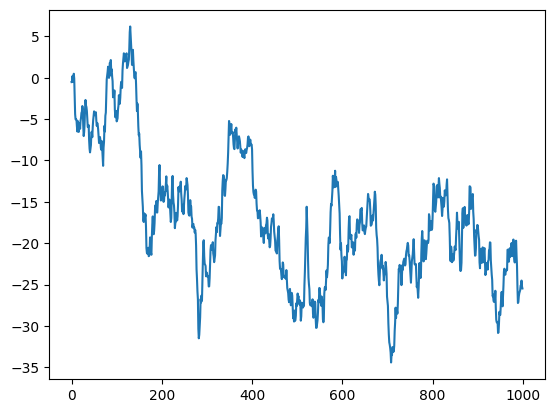

In [224]:
x_c = x.cumsum()
plt.plot(x_c);

# Integrálás (idősor esetén)

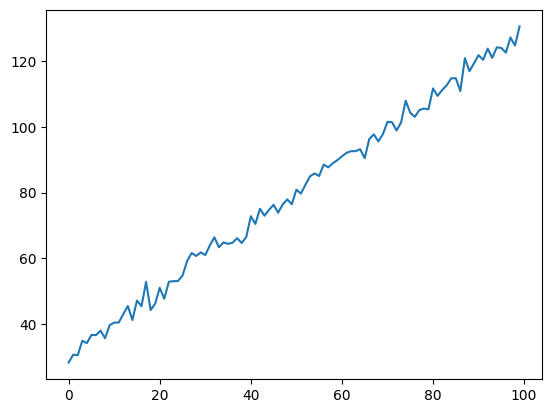

In [225]:
x = pd.Series(np.arange(10, 110) + np.random.normal(20, 2, 100))
x.plot();

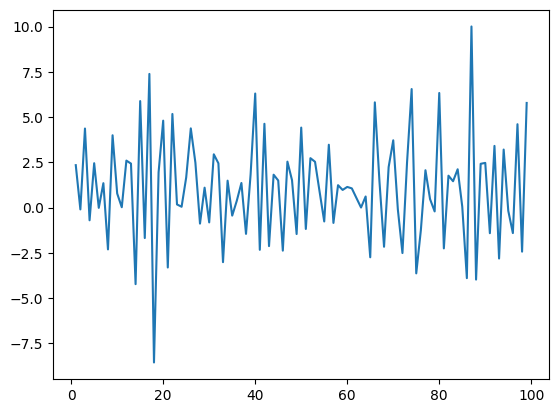

In [226]:
xd = x.diff().dropna()
xd.plot();

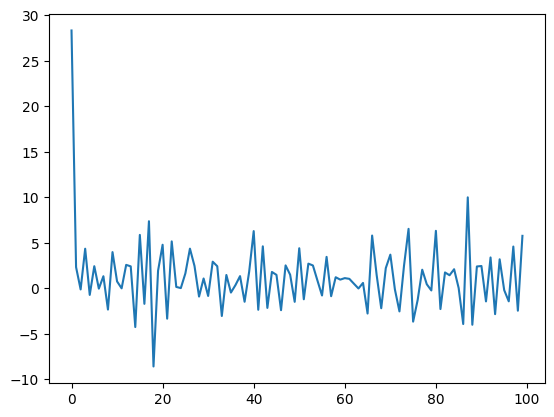

In [227]:
xd.loc[0] = x[0]
xd = xd.sort_index()
xd.plot();

In [228]:
pd.DataFrame({"x": x, "x_diff_1": xd.cumsum()})

,x,x_diff_1
0,28.344964,28.344964
1,30.687023,30.687023
2,30.581702,30.581702
3,34.949344,34.949344
4,34.242167,34.242167
...,...,...
95,123.957497,123.957497
96,122.543287,122.543287
97,127.148992,127.148992
98,124.707384,124.707384


In [235]:
ts

1949-01-01    20.600000
1950-01-01    20.900000
1951-01-01    20.200000
1952-01-01    19.600000
1953-01-01    21.600000
                ...    
2014-01-01     9.274849
2015-01-01     9.315223
2016-01-01     9.482656
2017-01-01     9.356081
2018-01-01     9.186887
Name: birth rate, Length: 70, dtype: float64

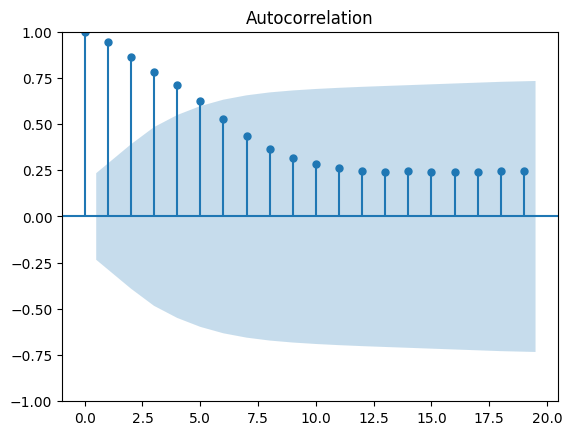

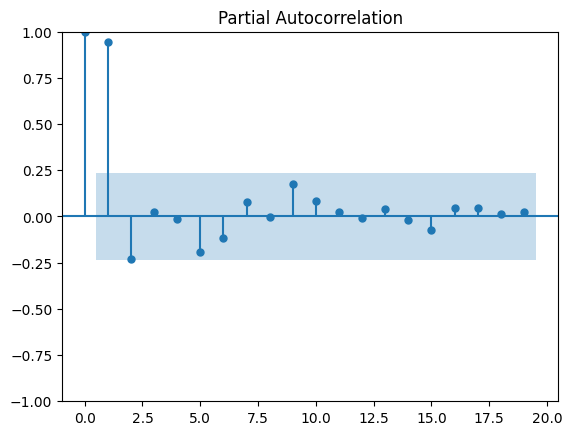

In [286]:
plot_acf(ts)
plot_pacf(ts)
plt.show()

In [240]:
model = SARIMAX(ts, order=(1, 1, 1)).fit()
model.summary()

c:\Users\witen\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\witen\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             birth rate   No. Observations:                   70
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -68.788
Date:                Tue, 26 Nov 2024   AIC                            143.576
Time:                        15:20:52   BIC                            150.278
Sample:                    01-01-1949   HQIC                           146.235
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1977      0.128      1.550      0.121      -0.052       0.448
ma.L1          0.4167      0.140      2.983      0.003       0.143       0.691
sigma2         0.4276      0.039     10.890      0.000       0.351       0.505
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               117.40
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                             1.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

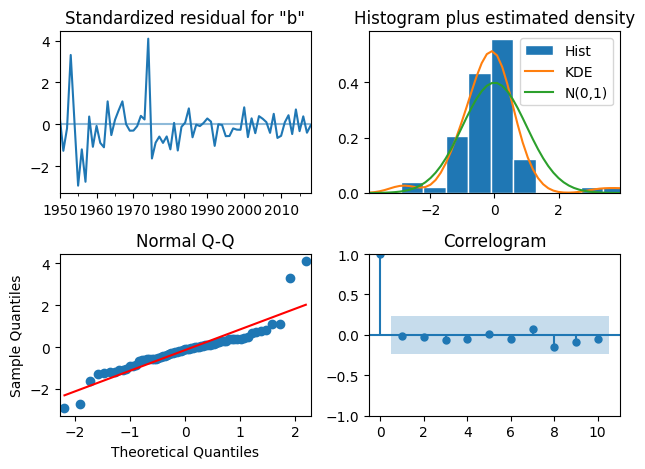

In [242]:
model.plot_diagnostics()
plt.tight_layout()

In [243]:
from pmdarima.arima import auto_arima

In [247]:
model = auto_arima(ts, information_criterion="aic")
model

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [248]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   70
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -69.203
Date:                Tue, 26 Nov 2024   AIC                            142.405
Time:                        15:23:20   BIC                            146.874
Sample:                    01-01-1949   HQIC                           144.178
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5604      0.115      4.864      0.000       0.335       0.786
sigma2         0.4328      0.041     10.666      0.000       0.353       0.512
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               113.81
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                             1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

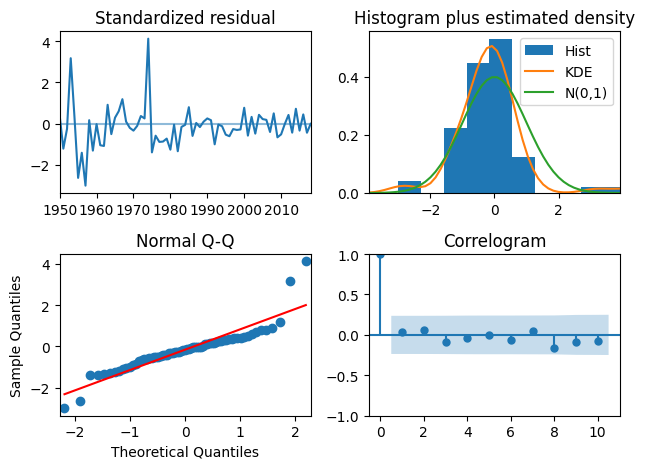

In [250]:
model.plot_diagnostics()
plt.tight_layout()

In [255]:
train = ts[ts.index[:50]]
test = ts[ts.index[50:]]

In [266]:
model = auto_arima(ts, information_criterion="aic")
model

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [270]:
model = SARIMAX(ts, order=(0,1,1)).fit()

c:\Users\witen\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\witen\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


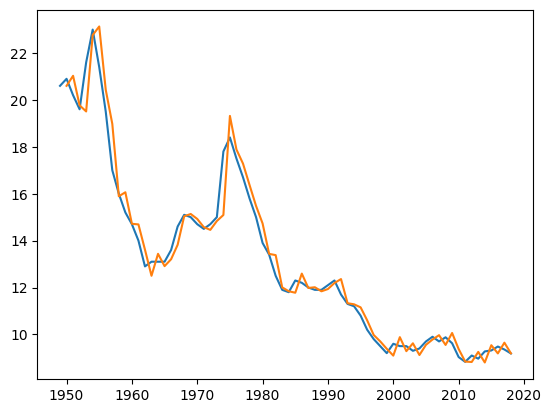

In [276]:
y_pred = model.predict()
plt.plot(ts)
plt.plot(y_pred[1:])
plt.show()

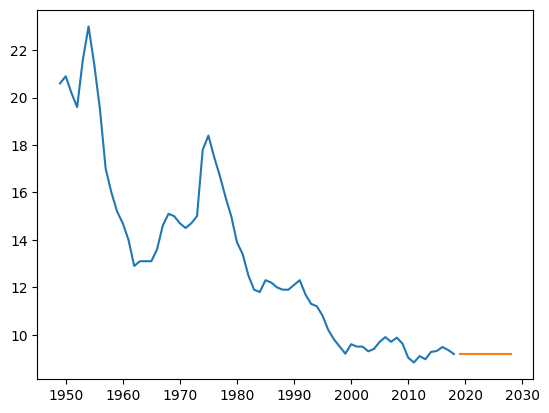

In [283]:
forecast = model.forecast(10)
plt.plot(ts)
plt.plot(forecast);

C:\Users\witen\AppData\Local\Temp\ipykernel_13664\1161873123.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["pred"] = results.get_forecast(steps=len(test)).predicted_mean


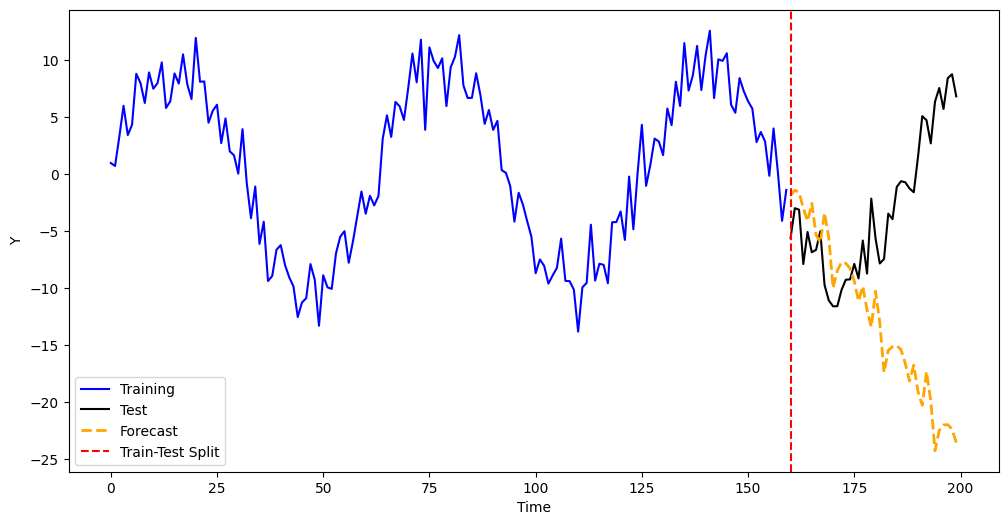

In [296]:
np.random.seed(42)
n = 200

t = np.linspace(0, 20, n)
y = 10 * np.sin(t) + np.random.normal(0, 2, n)

data = pd.DataFrame({"Y": y})

train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

model = SARIMAX(train["Y"], order=(2, 1, 2), seasonal_order=(1, 1, 0, 12), enforce_stationarity=False)
results = model.fit(disp=False)

test["pred"] = results.get_forecast(steps=len(test)).predicted_mean

mape = mean_absolute_percentage_error(test["Y"], test["pred"])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train["Y"], label="Training", color="blue", linewidth=1.5)
plt.plot(test["Y"], label="Test", color="black", linewidth=1.5)
plt.plot(test["pred"], label="Forecast", color="orange", linestyle="--", linewidth=2)
plt.axvline(x=train_size, color="red", linestyle="--", label="Train-Test Split")
plt.xlabel("Time")
plt.ylabel("Y")
plt.legend()
plt.show()
